# Part 1

In [695]:
import numpy as np
import matplotlib.pyplot as plt
import random
import numpy.linalg as la
import typing
from typing import List, Tuple, Callable
from sklearn.decomposition import PCA
import math
from tqdm import tqdm
from scipy.stats import multivariate_normal, norm



Experimental Constants

In [586]:
BOLT_NUM = 17
FRAME_RATE = 240

Loading vibration Data

In [587]:
data_dict = dict(np.load(r'data\\AutonomousTrajectoriesBig.npz'))
data_all = [it[1] for it in data_dict.items()]

In [588]:
data_dict.keys()

dict_keys(['T10', 'T11', 'T13', 'T20', 'T4', 'T18', 'T3', 'T14', 'T5', 'T17', 'T9', 'T23', 'T24', 'T21', 'T7', 'T6', 'T22', 'T12', 'T19', 'T15', 'T1', 'T2', 'T8', 'T16'])

In [589]:
print(len(data_all))
data_all[0].shape

24


(17, 7453)

# 1.1
 Reversing columns of the data matrices, so that data is in increasing time

In [590]:
ordered_data_all = []
for data_mat in data_all:
    ordered_data_all.append(data_mat[:, ::-1])

# ensuring that the data is reversed correctly
for mat_reverse, mat_forward in zip(data_all, ordered_data_all):
    assert np.allclose(mat_reverse[:, ::-1], mat_forward)


In [591]:
print(ordered_data_all[0][0, :])
print(data_all[0][0, :])
ordered_data_all[0].shape


[ 0.04094743  0.02806029  0.00584782 ...  0.0129485  -0.00066601
  0.00832467]
[ 0.00832467 -0.00066601  0.0129485  ...  0.00584782  0.02806029
  0.04094743]


(17, 7453)

At this point it's probably a good idea to visualise the data to get a clearer picture of the signal and any steady states

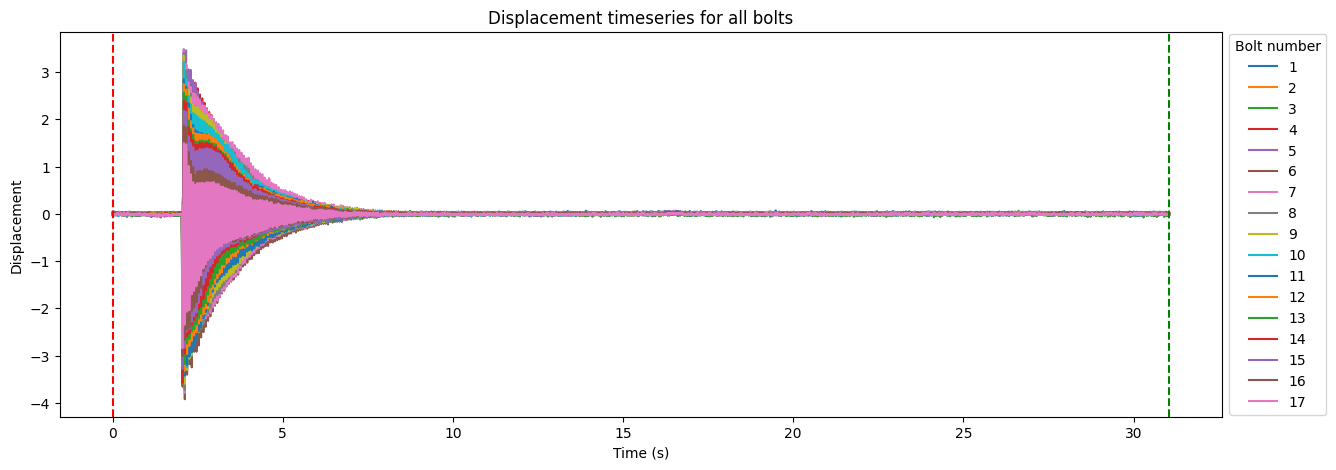

In [592]:
def get_time_from_frames(frames):
    t_final = frames / FRAME_RATE
    t = np.linspace(0, t_final, frames)
    return t

def plot_timeseries(data, start=0, stop=-1, fig_size=(15, 5), show_legend=True):
    fig, ax = plt.subplots(1, 1, figsize=fig_size)
    
    if stop == -1:
        stop = data.shape[1]

    # time of each measurement is determined based on the camera frame rate and the number of columns in the data array
    frame_count = data.shape[1]
    t = get_time_from_frames(frame_count)
    
    # t = t[start:stop+1]
    # plotting the timeseries data for each bolt
    for i in range(BOLT_NUM):
        ax.plot(t, data[i, :], label=f'{i+1}')
    
    ax.axvline(x=t[start], color='r', linestyle='--')
    ax.axvline(x=t[stop-1], color='g', linestyle='--')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Displacement')

    if show_legend:
        ax.legend(title='Bolt number', loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.title('Displacement timeseries for all bolts')
    plt.show()

plot_timeseries(ordered_data_all[0], start=0, stop=-1)



# 1.2 
We can clearly see the initial steady state and the long time steady state from the above plot. We can remove these from the data matrix whilst keeping the no. of columns consistent for each test by calculating the absolute mean and std of the displacement at each timestep accross all bolts 

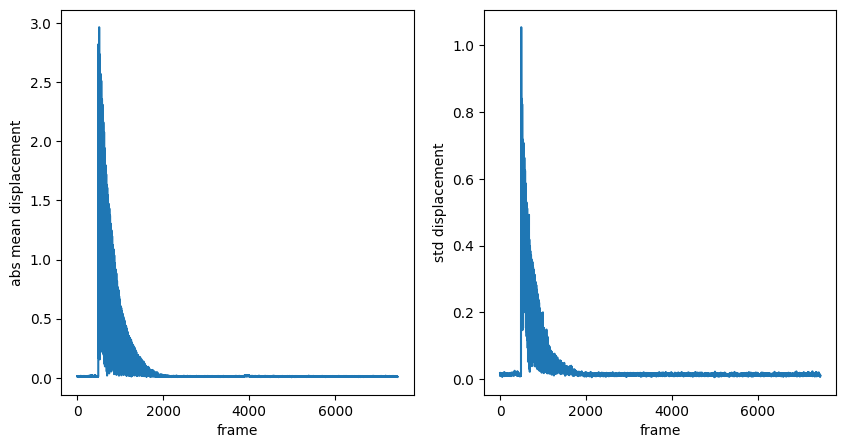

In [593]:
mean_series = np.mean(np.abs(ordered_data_all[0]), axis=0)
std_series = np.std(ordered_data_all[0], axis=0)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(mean_series)
axs[1].plot(std_series)
axs[0].set_xlabel('frame')
axs[0].set_ylabel('abs mean displacement')
axs[1].set_xlabel('frame')
axs[1].set_ylabel('std displacement')
plt.show()

We can see that, for this data the standard deviation is just a scaled and slightly noisier version of the mean, so lets just use the mean to clip the data. We can remove the steady state time by selecting points that exceed some minimum absolute mean. The problem is that some of the data matrices are noisier than others. A hacky way around this is that if we look at all of the data, every single experiment is definitely at a steady state after 20 seconds, so we can simply calculate the mean of the steady state for each matrix and use this as the threshold

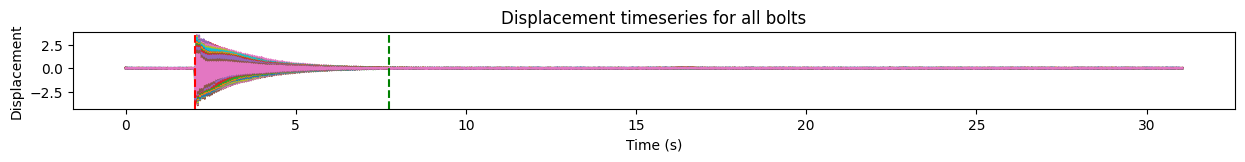

0.003280128183916986


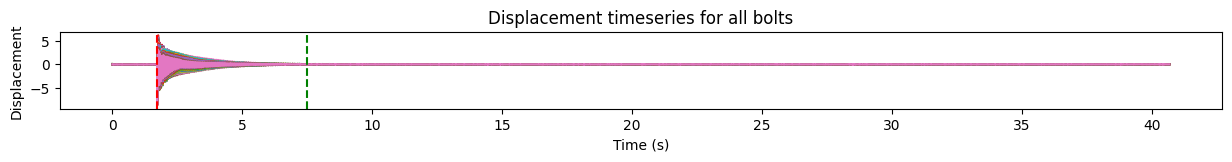

0.033836883882216284


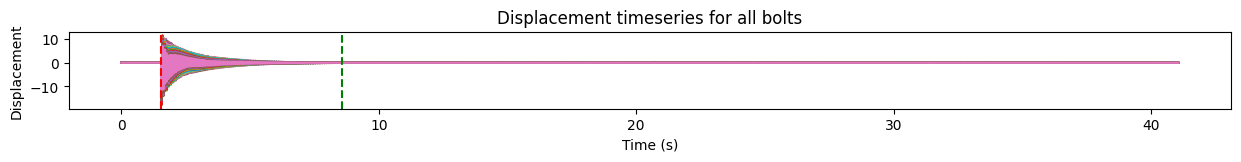

0.039653183300217165


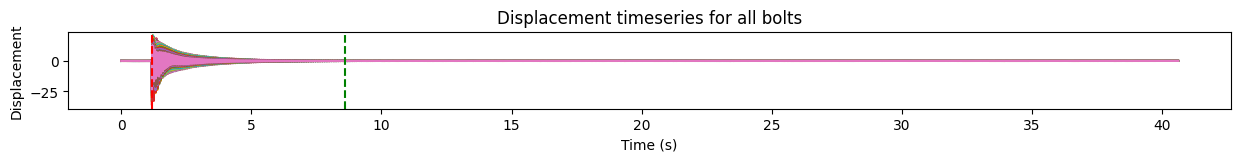

0.0020657720835970395


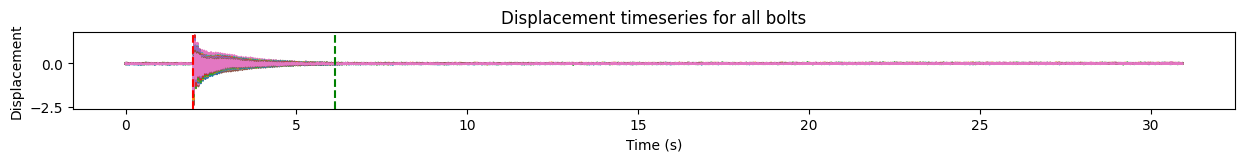

-0.010810469054803207


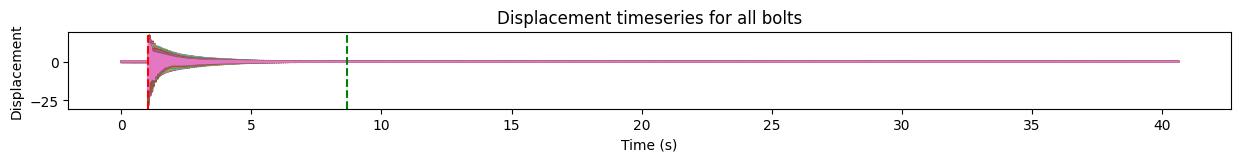

-0.19485295911709954


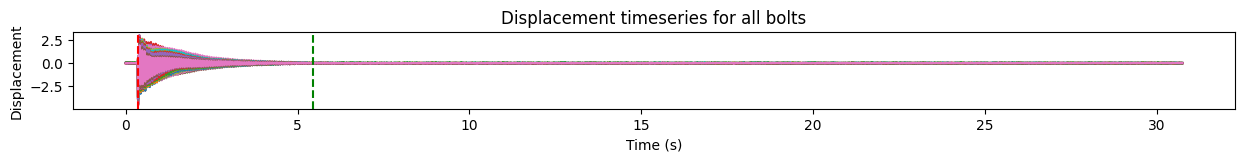

0.017415796417324714


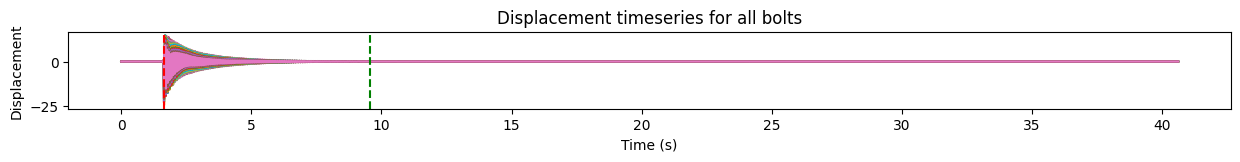

0.007211026436749535


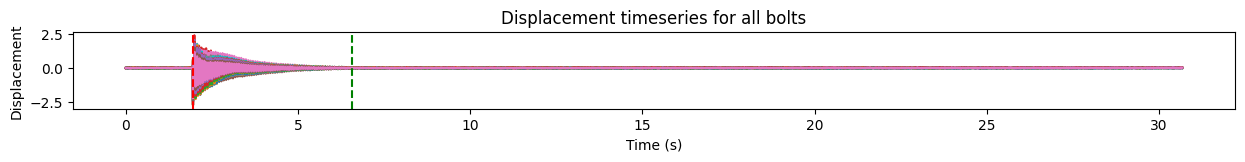

-0.00695187981486356


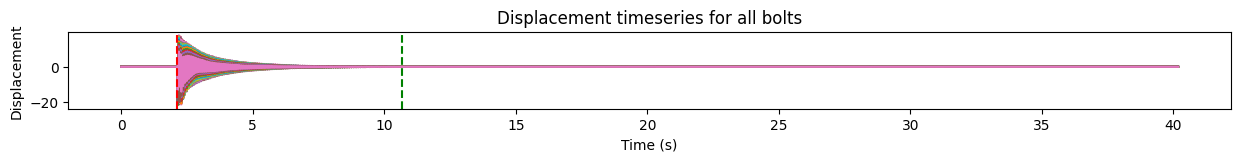

0.010914329013203883


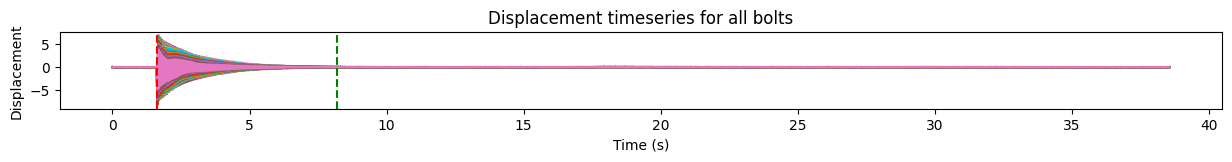

0.011671715592939336


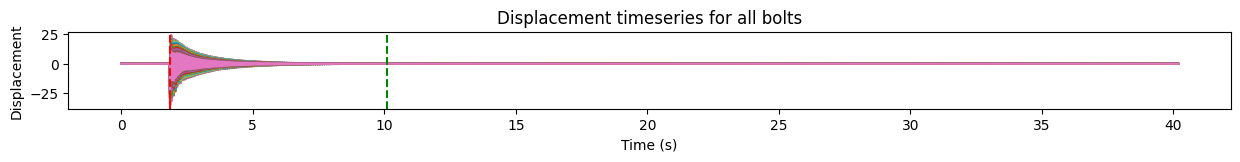

0.002035094640916668


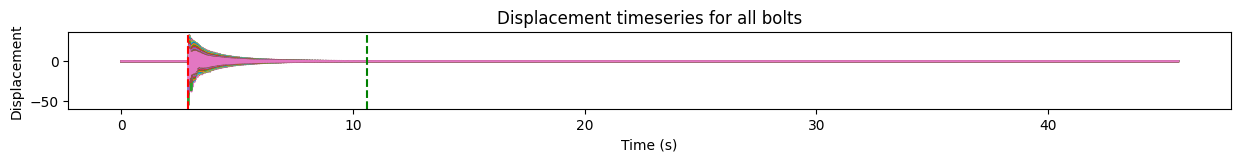

0.02523131108365817


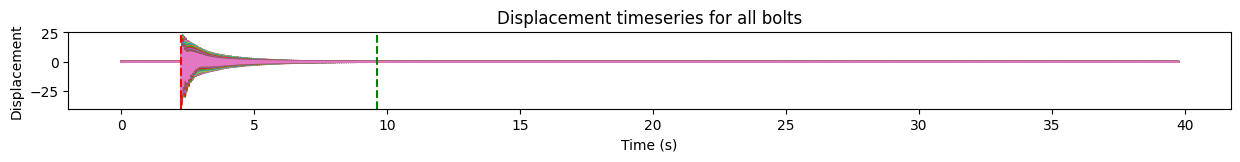

0.006138494102742698


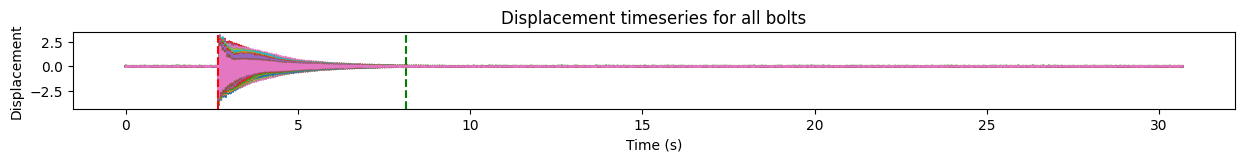

-0.0045405737731840645


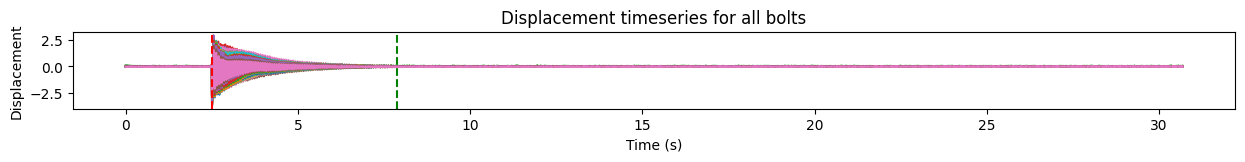

0.02359508696241619


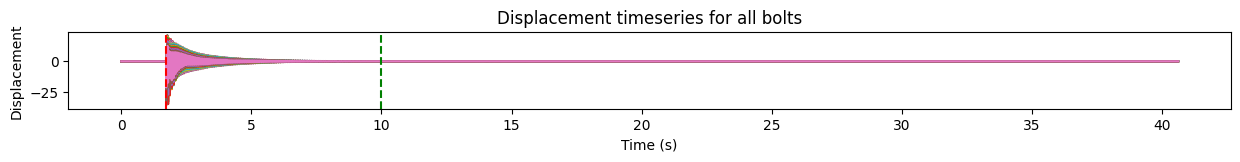

0.02699415673907879


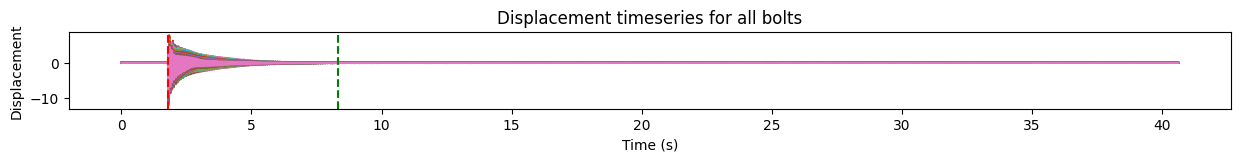

0.03201238600790646


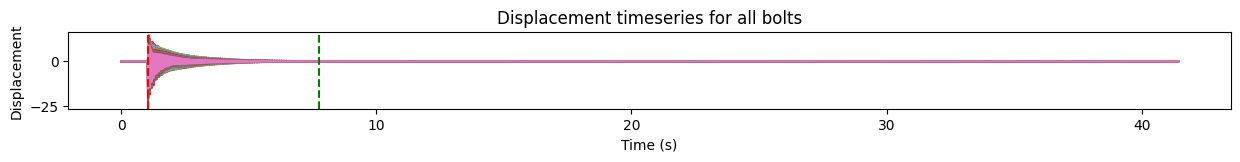

-0.029400273953172018


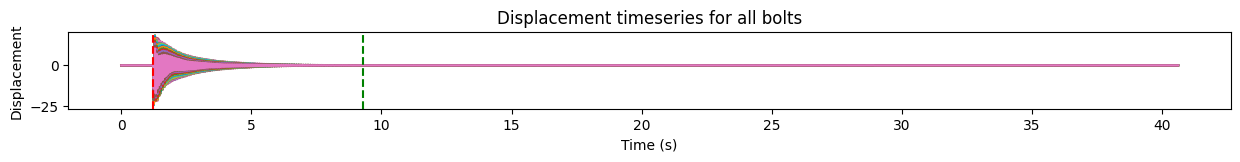

0.012416015351490728


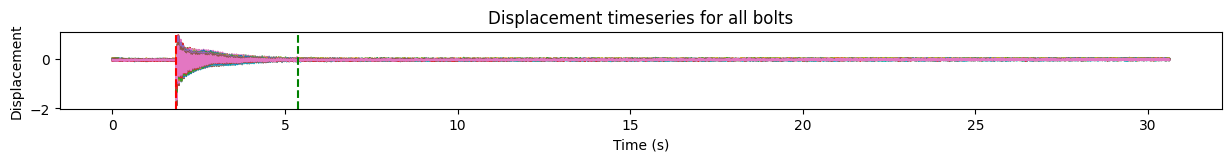

-0.001367060177528856


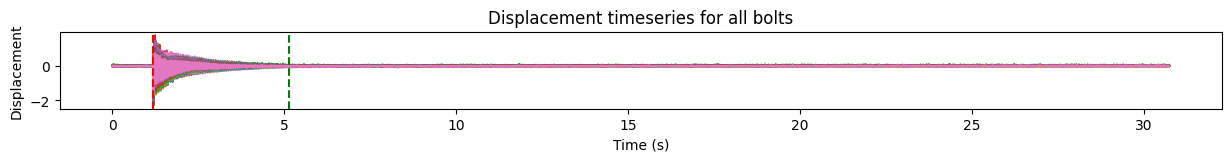

0.019305401938751743


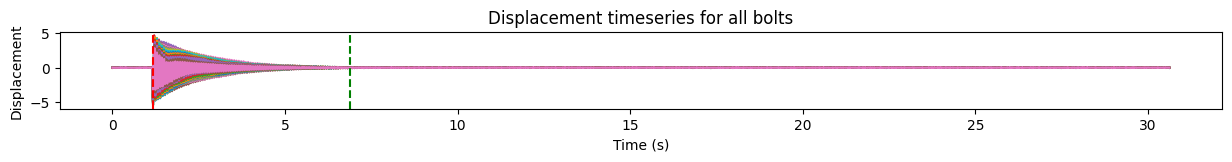

0.011071170309463696


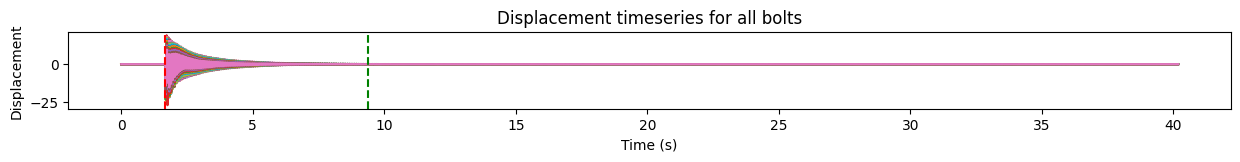

0.01860129345860173


In [594]:
def find_steady_state(data):
    # timeseries of mean displacement across all bolts
    mean_series = np.mean(abs(data), axis=0)
    # std_series = np.std(data, axis=0)
    
    # getting the maximum mean and std values accross each bolt after t=20s
    t = get_time_from_frames(data.shape[1])
    steady_start = np.where(t > 20)[0][0]
    mean_threshold =  2* np.max(mean_series[steady_start:]) # fudge factor of 1.4 determined empirically
    # std_threshold = 1.4 *np.max(std_series[steady_start:])
    
    # getting indices of the transient state using mean and std thresholds
    transient_indices = np.where(mean_series > mean_threshold)[0]
    # transient_std = np.where(std_series > std_threshold)
    # transient_indices = np.intersect1d(transient_mean, transient_std)
    # stop at the last transient index
    stop = transient_indices[-1]
    # start index can be calculated in a more straightforward way
    max_mean = np.max(mean_series)
    start = np.where(mean_series > 0.05*max_mean)[0][0]

    return start, stop

# visually validating the start and stop positions
for i, data in enumerate(ordered_data_all):
    start, stop = find_steady_state(data)
    plot_timeseries(data, start=start, stop=stop, fig_size=(15, 1), show_legend=False)
    # trimming the data
    ordered_data_all[i] = data[:, start:stop]

    print(data[5,5])





# 1.3
Now let's ensure that each trajectory has zero mean (oscillation about 0 displacement). 

In [595]:
def zero_mean(data):
    return data - np.mean(data, axis=1, keepdims=True)

ordered_data_all = [zero_mean(data) for data in ordered_data_all]

# validating that zeroing the mean has worked
for data in ordered_data_all:
    assert np.allclose(np.mean(data, axis=1), 0, rtol=1e-15), 'Mean is not zeroed to machine precision'

### 1.4
We do not know that the damping in the system is linear, therefore we cannot be certain that it is independent of the magnitude of displacement, so the rescaling should take place accross all matrices aggregated instead of individually. scaling values between 1 and -1 can be benificial for numerical stability. EXPAND ON THIS

In [596]:
print("shape pre scaling", ordered_data_all[0].shape)

scale = -1
for data in ordered_data_all:
    abs_max = np.max(np.abs(data))
    if abs_max > scale:
        scale = abs_max

print("max absolute displacement in dataset =", scale)

for i, data in enumerate(ordered_data_all):
    ordered_data_all[i] = data / scale



# validating that the data has been scaled correctly
for i, data in enumerate(ordered_data_all):
    max_displacement = np.max(np.abs(data))
    assert (max_displacement <= 1), 'Data is not scaled correctly'
    print("test {}, max displacement = {}".format(i, max_displacement))

print("shape post scaling", ordered_data_all[0].shape)

shape pre scaling (17, 1372)
max absolute displacement in dataset = 55.46775699558333
test 0, max displacement = 0.07005651724158175
test 1, max displacement = 0.15654541568814206
test 2, max displacement = 0.3231680426284947
test 3, max displacement = 0.6552505859459072
test 4, max displacement = 0.04296827552222181
test 5, max displacement = 0.5071169120550245
test 6, max displacement = 0.08121602275066295
test 7, max displacement = 0.4436217608274429
test 8, max displacement = 0.04902147374933886
test 9, max displacement = 0.3919215798774791
test 10, max displacement = 0.14819074453617528
test 11, max displacement = 0.6315203222146079
test 12, max displacement = 1.0
test 13, max displacement = 0.6657477583892121
test 14, max displacement = 0.07210722044831228
test 15, max displacement = 0.06523782190169752
test 16, max displacement = 0.6534899482330756
test 17, max displacement = 0.216436221230474
test 18, max displacement = 0.4454679558379344
test 19, max displacement = 0.440855161

### plotting the final dataset as a sanity check


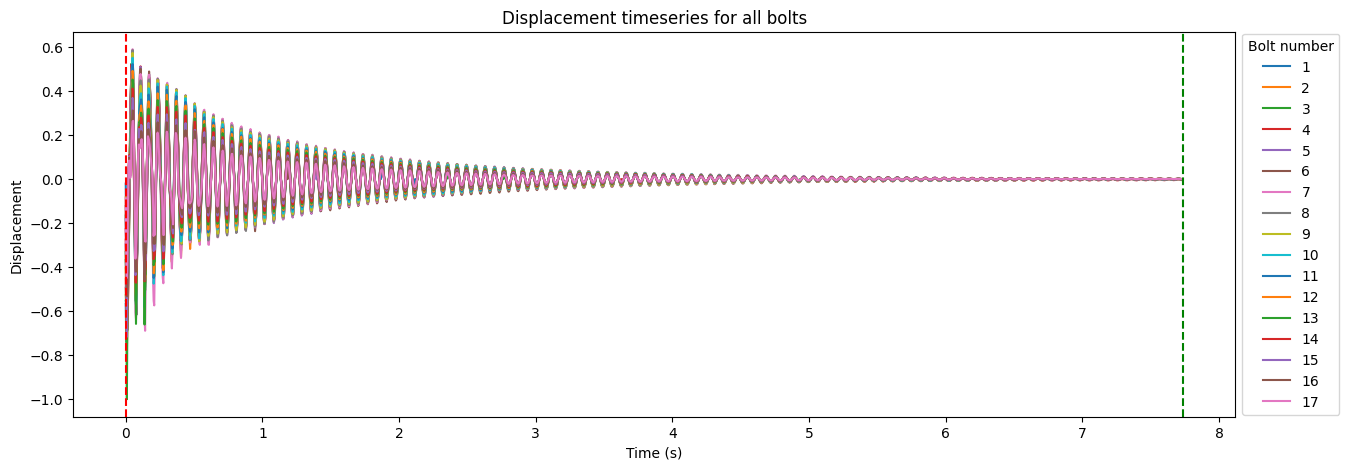

In [597]:
plot_timeseries(ordered_data_all[random.randint(0, len(ordered_data_all)-1)], start=0, stop=-1)

# 1.5
Optional. Skipping for now

# 2.1

It is necissary to seperate the data into a training and testing set to ensure that our model is not overfit to the training data. If it performs well on the training data, but poorly on the test data, the model is likely overfit.

Since we don't have a lot of data, we'll do a 80-20 train-test split.

In [598]:
shuffled_data = random.sample(ordered_data_all, len(ordered_data_all))
train_data = shuffled_data[:int(len(shuffled_data)*0.8)]
test_data = shuffled_data[int(len(shuffled_data)*0.8):]

print(len(train_data), len(test_data))

19 5


# 2.2

We are using delay embedding to determine the states and linear model which generate the observed data. Assuming that the system is observable

Given each data matrix consists of $y_1, y_2, \cdots, y_n$, where $y_i$ is a vector containing the displacement of each of the 17 bolts at frame, I can form a Hankel matrix by choosing some arbitrary dimensionality, and then ensure that it is large enough to capture the unobserved state space afterwards.

In [599]:

def hankel_matrix(data: np.array, delay: int):
    """
    Generates a hankel matrix by vertically stacking the delayed versions of the data matrix by delay timesteps
    args:
    ------
    data: np.array, timeseries of shape (n,m) where m is the number of timesteps and n is the number of features
    delay: int, delay window size

    returns:
    --------
    hankel: np.array, hankel matrix of shape (delay*n, m-delay+1)
    """
    n = data.shape[0]
    m = data.shape[1]
    
    hankel = np.zeros((delay*n, m-delay+1))
    for i in range(delay):
        hankel[i*n:(i+1)*n, :] = data[:, i:m-delay+(i+1)] 
    return hankel

print("original shape")
print(ordered_data_all[0].shape)

test_hankel = hankel_matrix(ordered_data_all[0], 5)
print("hankel shape")
print(test_hankel.shape)
print("first 4 columns of hankel (first variable)")
print(test_hankel[::17, :4])
print("last 4 columns of hankel")
print(test_hankel[::17, -4:])

original shape
(17, 1372)
hankel shape
(85, 1368)
first 4 columns of hankel (first variable)
[[-0.00051698 -0.0056263  -0.01769047 -0.03033753]
 [-0.0056263  -0.01769047 -0.03033753 -0.03739473]
 [-0.01769047 -0.03033753 -0.03739473 -0.04681964]
 [-0.03033753 -0.03739473 -0.04681964 -0.04283663]
 [-0.03739473 -0.04681964 -0.04283663 -0.02665065]]
last 4 columns of hankel
[[ 4.31936879e-04  5.43727475e-04 -6.72294625e-05  1.18850251e-04]
 [ 5.43727475e-04 -6.72294625e-05  1.18850251e-04 -1.74767551e-04]
 [-6.72294625e-05  1.18850251e-04 -1.74767551e-04  1.12738603e-04]
 [ 1.18850251e-04 -1.74767551e-04  1.12738603e-04 -4.36993783e-04]
 [-1.74767551e-04  1.12738603e-04 -4.36993783e-04 -3.47009706e-04]]


In [600]:
def decorrelate(data: np.array, kappa: float = 1e6, verbose: bool = True):
    """
    data: np.array, data matrix to decorrelate, row wise
    """
    # performing SVD on the correlation matrix
    cor_mat = data @ data.T
    U, s_vec, _ = np.linalg.svd(cor_mat, full_matrices=False, hermitian=True) # economy svd and correlation matrix is symmetric
    # selecting columns of u that satisfy stability condition
    significant_cols = np.where(s_vec[0] / s_vec < kappa)[0]
    U = U[:, significant_cols]
    decorrelated = U.T @ data

    if verbose:
        print("Decorrelating data: \n")
        print(" U, S shape: ", U.shape, s_vec.shape, "\n")
        print(" first 5 singular values: ", s_vec[:5], "\n")
        print(" U shape after filtering: ", U.shape, "\n")
        print("-----------------------------\n")
        
    return decorrelated, U

# testing decorrelation
decorrelated_test, U = decorrelate(test_hankel, kappa=1e6)
print("decorrelated shape")
print(decorrelated_test.shape)

Decorrelating data: 

 U, S shape:  (85, 85) (85,) 

 first 5 singular values:  [14.99338417  4.98578788  0.20553669  0.1638617   0.02111771] 

 U shape after filtering:  (85, 85) 

-----------------------------

decorrelated shape
(85, 1368)


Now we need to fit a linear model to the delay embedded and decorellated data to produce the observed output data.

In [601]:
def linear_delay_embedding(data: np.array, delay: int = 10, kappa: float = 1e6):
    """
    Fits a least squares linear model to predict the next state surrogate from the previous state surrogate
    using a delay embedding size given by delay. 

    args:
    -----
    data: np.array, timeseries of shape (n, m) where m is the number of timesteps and n is the number of features 
    delay: int, delay embedding window size
    kappa: float, threshold for decorrelation
    
    returns:
    --------
    W: np.array, linear model weights
    U: np.array, LHS Matrix from SVD, for switching between decorrelated state surrogate and observed/predicted outputs
    X_prev: np.array, decorrelated previous state surrogate matrix
    X_next: np.array, decorrelated next state surrogate matrix
    """
    # delay embedding the observed outputs 
    hankel = hankel_matrix(data, delay)
    # previous timestep and next timestep state surrogate matrices
    X_prev = hankel[:, :-1]
    X_next = hankel[:, 1:]
    # decorrelated input state surrogate matrix
    _, U = decorrelate(hankel, kappa=kappa, verbose=False)
    # decorrelated state surrogates
    X_prev = U.T @ X_prev
    X_next = U.T @ X_next

    # fitting a linear model to predict the next surrogate state, i.e. X_next = W @ X_prev
    W = (X_next @ X_prev.T) @ la.pinv(X_prev @ X_prev.T, rcond=1e-6)

    return W, U, X_prev, X_next

def predict(W: np.array, U: np.array, data: np.array, delay: int = 10):
    """
    predicts the output state at the next timestep using the linear delay embedding model, 
    with learned weights W and delay d, with decorrelation matrix U.
    
    args:
    -----
    W: np.array, linear model weights
    U: np.array, LHS Matrix from SVD, for decorrelation
    data: np.array, test trajectory of shape (n,m) where m is the number of timesteps and n is the number of features
    d: int, delay embedding window size

    returns:
    --------
    Y_pred: np.array, predicted output trajectory
    prediction_rmse: float, root mean squared error of the prediction vs the actual output
    """
    # delay embedding matrix
    hankel = hankel_matrix(data, delay)
    # decorrelated previous state surrogate matrix
    X_prev = U.T @ hankel[:, :-1]
    X_next = U.T @ hankel[:, 1:]
    
    # predicting the next state surrogate
    X_next_pred = W @ X_prev
    
    # predicting the output
    Y_pred = U[0:data.shape[0], :] @ X_next_pred

    # calculating the rmse of the predictions for each output dim. 
    # Rescaled to account for the dimensionality of the data (mean term cancels out)
    rmse_features = la.norm(X_next - X_next_pred, axis=1) / la.norm(np.ones(X_next.shape[1]))
    # standard deviation of rmse accross features
    rmse_std = np.std(rmse_features)
    
    prediction_rmse = np.mean(rmse_features)

    return Y_pred, prediction_rmse, rmse_std

# training and testing the linear delay embedding model
stacked_train_data = np.hstack(train_data)
stacked_test_data = np.hstack(test_data)

delay = 5
kappa = 1e6
W, U, _, _ = linear_delay_embedding(stacked_train_data, delay=delay, kappa=kappa)

_, train_rmse, _ = predict(W, U, stacked_train_data, delay=delay)
_, test_rmse, _ = predict(W, U, stacked_test_data, delay=delay)

print("train mse: ", train_rmse)
print("test mse: ", test_rmse)



train mse:  0.001705079712636467
test mse:  0.0010617925160117776


Now that we have a delay embedding regime that appears to work, lets just do a quick sanity check to validate that it is correctly predicting outputs

test series shape (17, 1372)
Y_pred shape (17, 1367)
Y_pred shape after padding (17, 1372)


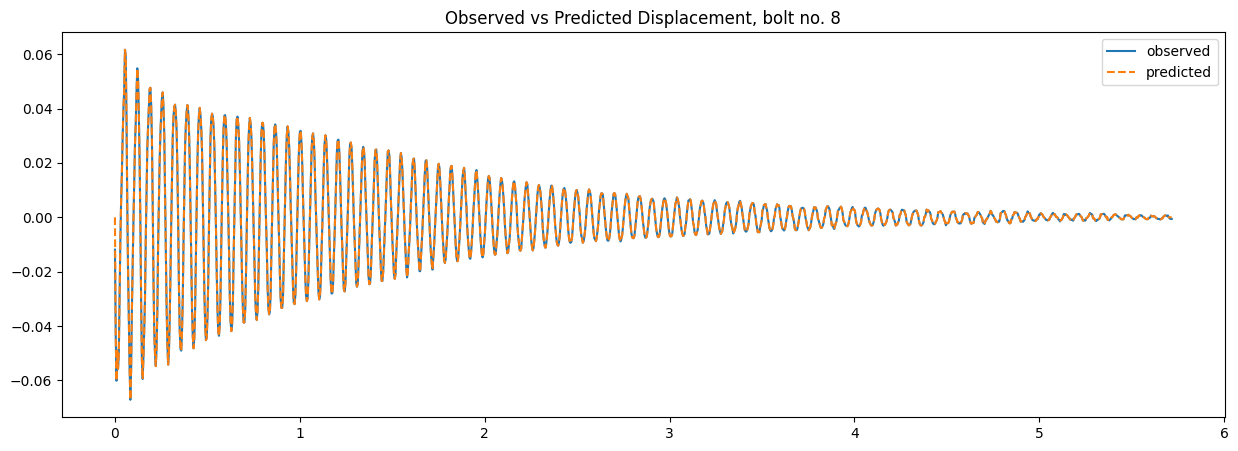

In [602]:
test_series = test_data[0]
Y_pred, _, _ = predict(W, U, test_series, delay=delay)

print("test series shape", test_series.shape)
print("Y_pred shape", Y_pred.shape)

# setting initial values to zero for plotting
n = test_series.shape[0]
Y_pred = np.hstack([np.zeros((n,1)), Y_pred, np.zeros((n,delay-1))])

print("Y_pred shape after padding", Y_pred.shape)

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
t = get_time_from_frames(test_series.shape[1])
randind = random.randint(0, n-1)
ax.plot(t, test_series[randind,:], label='observed')
ax.plot(t, Y_pred[randind,:], label='predicted', linestyle='--')      
ax.legend()
plt.title('Observed vs Predicted Displacement, bolt no. {}'.format(randind+1))
plt.show()


when calculating the root mean squared error, we run into the issue that naturally as the number of dimensions increases, the norm of the prediction matrix increases even if the relative errors are less. To account for this we can rescale the equation in the following way. This can be repeated for each feature.

$\frac{\|actual - pred \|_2}{\sqrt{size(actual)}} \times \frac{\sqrt{size(actual)}}{\|ones\_like(actual)\|_2} = \frac{\|actual - pred \|_2}{\|ones\_like(actual)\|_2}$

## 2.2 and 2.3

Lets find the smallest delay such that the difference between the train and test error is smaller than 10%. We can also look at the standard deviation during this task.

In [603]:
def train_and_compare(train, test, delay, kappa=1e6):
    W, U, _, _ = linear_delay_embedding(stacked_train_data, delay=delay, kappa=kappa)

    _, train_rmse, train_error_std = predict(W, U, stacked_train_data, delay=delay)
    _, test_rmse, test_error_std = predict(W, U, stacked_test_data, delay=delay)

    print("delay:", delay, "train mse: ", train_rmse, "test mse: ", test_rmse)
    error_ratio = (test_rmse / train_rmse) - 1

    return error_ratio, (train_rmse, test_rmse), (train_error_std, test_error_std)

# testing the error ratio for different delay values
max_delay = 20
ratios = []
train_stds = []
test_stds = []
train_errors = []
test_errors = []

delays = list(range(2, max_delay+1))
for delay in delays:
    # TODO: see if it is possible to improve the fitting procedure so that less than 10% difference in error is achieved
    error_ratio, errors, stds = train_and_compare(stacked_train_data, stacked_test_data, delay)
    
    print(f"delay = {delay}, error ratio = {error_ratio}")
    
    # storing values for plotting
    ratios.append(error_ratio)
    train_stds.append(stds[0])
    test_stds.append(stds[1])
    train_errors.append(errors[0])
    test_errors.append(errors[1])



delay: 2 train mse:  0.003037062870823379 test mse:  0.0018317783112114696
delay = 2, error ratio = -0.3968586133632276
delay: 3 train mse:  0.0024087663664928926 test mse:  0.0014510338031483506
delay = 3, error ratio = -0.3976029293114791
delay: 4 train mse:  0.0019780791129248598 test mse:  0.001199553376862054
delay = 4, error ratio = -0.3935766426003302
delay: 5 train mse:  0.001705079712636467 test mse:  0.0010617925160117776
delay = 5, error ratio = -0.3772769049196013
delay: 6 train mse:  0.0015387168924407846 test mse:  0.0009666220089655026
delay = 6, error ratio = -0.3717999628689319
delay: 7 train mse:  0.0013888062094664668 test mse:  0.000888148210271963
delay = 7, error ratio = -0.36049521940634177
delay: 8 train mse:  0.0012459926986143394 test mse:  0.000794115610318334
delay = 8, error ratio = -0.3626643148058051
delay: 9 train mse:  0.0011824774738111103 test mse:  0.000758743207842909
delay = 9, error ratio = -0.35834447196910313
delay: 10 train mse:  0.001120330299

### 3.4
Visualising how the standard deviations vary with time

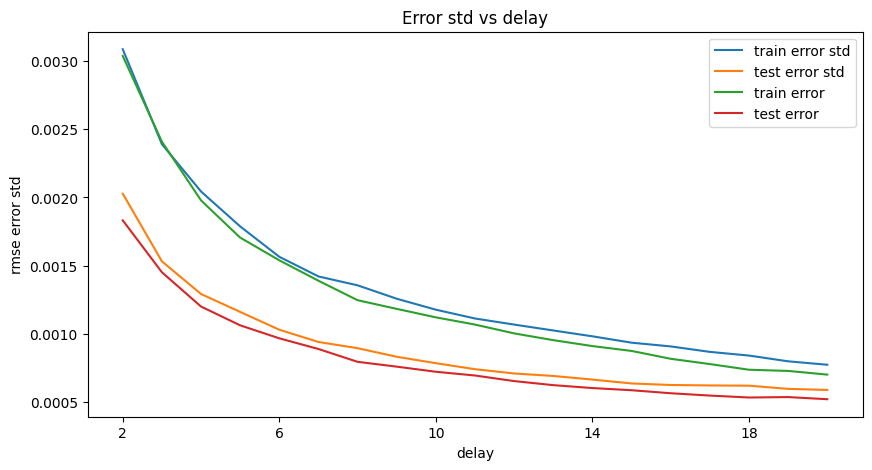

In [604]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(delays, train_stds, label='train error std')
ax.plot(delays, test_stds, label='test error std')
ax.plot(delays, train_errors, label='train error')
ax.plot(delays, test_errors, label='test error')
ax.legend()
plt.title('Error std vs delay')
ax.set_xlabel('delay')
ax.set_ylabel('rmse error std')
ax.set_xticks(delays[::4])
plt.show()

We can see from the plot that as the delay increases, the standard deviation of error between each of the feature predictions decreases. The high standard deviation for lower delay lengths suggests that some bolts are more accurately predicted than others. The fact that the RMSE closley follows the standard deviation, confirms this suspicion, as it suggests that error values are between zero and the standard deviation for each of the trails.

TODO determine the best delay embedding

# Problem 3

## 3.1
I'm now going to reimplement the linear model using dimensionality reduction and a delay value of 8. Instead of using SVD alone it makes more sense to use PCA, since this preserves the variance of the data. In fact the data has already been centered so principle components are simply decorrelated data points using SVD.

In [605]:
def pca_transform(data: np.array, n_components: int = 2):
    """
    projects the data matrix with shape (no. bolts, no. timesteps) to (n_components, no. timesteps) using PCA.
    Data should be centered before applying PCA (which it already is in this case).
    """
    pca = PCA(n_components=n_components)
    compressed_data = pca.fit_transform(data.T) # transposing the data matrix to get the correct shape for the function
    total_explained_variance = np.sum(pca.explained_variance_ratio_)

    return compressed_data.T, total_explained_variance

def PCA_linear_test():
    dimensions = list(range(1, train_data[0].shape[0]+1))
    delay = 8

    train_rmses = []
    test_rmses = []
    train_stds = []
    test_stds = []
    explained_train_var = []

    for dim in dimensions:
        train_compressed, train_comp_var = pca_transform(stacked_train_data, n_components=dim)
        test_compressed, _ = pca_transform(stacked_test_data, n_components=dim)

        W, U, _, _ = linear_delay_embedding(train_compressed, delay=delay, kappa=kappa)

        _, train_rmse, train_std = predict(W, U, train_compressed, delay=delay)
        _, test_rmse, test_std = predict(W, U, test_compressed, delay=delay)

        train_rmses.append(train_rmse)
        test_rmses.append(test_rmse)
        train_stds.append(train_std)
        test_stds.append(test_std)
        explained_train_var.append(train_comp_var)

    # plotting errors vs PCA dimension
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.plot(dimensions, train_rmses, label='train error')
    ax.plot(dimensions, test_rmses, label='test error')
    ax.plot(dimensions, train_stds, label='train error std')
    ax.plot(dimensions, test_stds, label='test error std')
    ax.legend()
    plt.title('RMSE vs PCA dimension')
    ax.set_xlabel('PCA dimensions')
    ax.set_ylabel('RMSE')
    plt.show()

    # plotting the total explained variance ratio
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.plot(dimensions, explained_train_var)
    plt.title('Explained variance ratio vs PCA dimension')
    ax.set_xlabel('Principle Components')
    ax.set_ylabel('Explained variance ratio')
    plt.show()




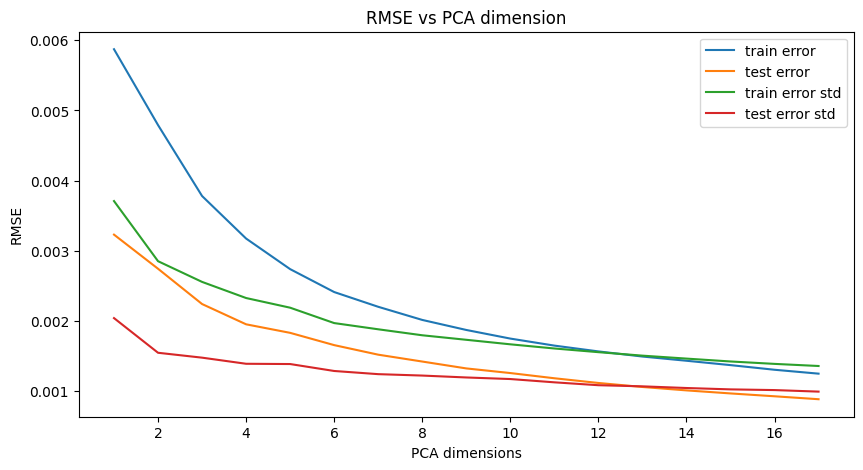

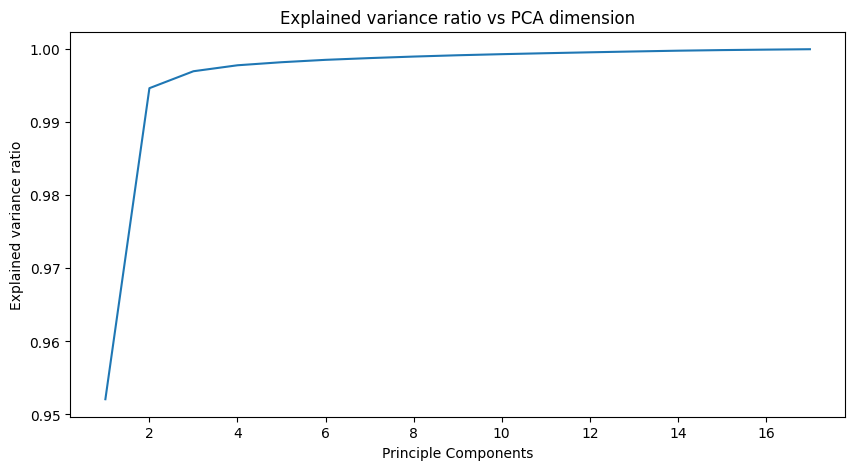

In [606]:
PCA_linear_test()

For the linear model we see that as the projected dimension decreases, the train and test errors grow at a roughly equivalent rate, although notably, the effect of dimensionality reduction seems to impose significantly less model prediction error than decreasing the delay of the hankel matrix. Interestingly the standard deviation of RMSE between the bolts stays roughly constant, implying that the distribution of error with bolt position remains similar.

In fact if we look at the total explained variance ratio for against number of Principle Components, we see that one dimension alone acounts for 95% of the variance in the original 17 dimensional data, suggesting that each of the bolts in the experiment roughly follow the same dynamics.

THINK MORE ON THIS + INVESTIGATE SOURCE OF SPIKE IN TEST ERROR ABOVE 2 DIMS. THEORY IS SCALING ISSUE WITH RMSE


## 3.2

To Fit a quadratic and polynomial model we will have to use a library of nonlinear functions for training, so we must implement this first. If we define a library of nonlinear functions, $\Phi$ then the fitting precedure is loosely

$$
\tilde{X}_{\mathrm{prev}} = \Phi(\hat{X}_{\mathrm{prev}})
$$

$$
W = \hat{X}_\mathrm{next} \tilde{X}_{\mathrm{prev}}^T\big(\tilde{X}_{\mathrm{prev}} \tilde{X}_{\mathrm{prev}}^T\big)^+
$$

$$
\bm{\hat{x}}_{k+1} = W\Phi(\bm{\hat{x}}_{k})
$$

where hats denote decorrelated data and capital X terms are in hankel matrix form

In [607]:
def nonlinear_delay_embedding(data: np.array, func_library: List[Callable], delay: int = 10, kappa: float = 1e6):
    """
    Fits a non-linear delay embedding model to predict the next state surrogate from a nonlinear transformation 
    of the previous state surrogate, where the list of applied nonlinear functions is given by func_library.  

    args:
    -----
    data: np.array, timeseries of shape (n, m) where m is the number of timesteps and n is the number of features 
    func_library: List[Callable], list of functions to apply to the previous state surrogate
    delay: int, delay embedding window size
    kappa: float, threshold for decorrelation
    
    returns:
    --------
    W: np.array, non-linear model weights of shape (n, funcs*n)
    U: np.array, LHS Matrix from SVD, for switching between decorrelated state surrogate and observed/predicted outputs
    """
    # delay embedding the observed outputs
    hankel = hankel_matrix(data, delay)
    # previous timestep and next timestep state surrogate matrices
    X_prev = hankel[:, :-1]
    X_next = hankel[:, 1:]
    # decorrelated input state surrogate matrix
    _, U = decorrelate(hankel, kappa=kappa, verbose=False)
    # decorrelated state surrogates
    X_prev = U.T @ X_prev
    X_next = U.T @ X_next

    # applying the library of functions to the previous state surrogates
    func_evals = []
    for func in func_library:
        func_eval = func(X_prev)
        func_evals.append(func_eval)

    nl_X_prev = np.concatenate(func_evals, axis=0) # result is (funcs*n, obs-delay)
    
    # fitting a linear model to the new nonlinear state space
    W = (X_next @ nl_X_prev.T) @ la.pinv(nl_X_prev @ nl_X_prev.T, rcond=1e-6)

    return W, U

def predict_nonlinear(W: np.array, U: np.array, data: np.array, func_library: List[Callable], delay: int):
    """
    predicts the output state at the next timestep using a non-linear delay embedding model, 
    with learned weights W, delay d, decorrelation matrix U and a library of non-linear functions
    given by func_library.
    
    args:
    -----
    W: np.array, linear model weights of shape (n, funcs*n)
    U: np.array, LHS Matrix from SVD, for decorrelation
    data: np.array, test trajectory of shape (n,m) where m is the number of timesteps and n is the number of features
    d: int, delay embedding window size

    returns:
    --------
    Y_pred: np.array, predicted output trajectory
    prediction_rmse: float, root mean squared error of the prediction vs the actual output
    """
    # delay embedding matrix
    hankel = hankel_matrix(data, delay)
    # decorrelated previous state surrogate matrix
    X_prev = U.T @ hankel[:, :-1]
    X_next = U.T @ hankel[:, 1:]
    
    func_evals = []
    for func in func_library:
        func_eval = func(X_prev)
        func_evals.append(func_eval)

    nl_X_prev = np.concatenate(func_evals, axis=0) # result is (funcs*n, obs-delay)
    
    # predicting the next state surrogate
    X_next_pred = W @ nl_X_prev
    
    # predicting the output
    Y_pred = U[0:data.shape[0], :] @ X_next_pred

    # calculating the rmse of the predictions for each output dim. 
    # Rescaled to account for the dimensionality of the data (mean term cancels out)
    rmse_features = la.norm(X_next - X_next_pred, axis=1) / la.norm(np.ones(X_next.shape[1]))
    # standard deviation of rmse accross features
    rmse_std = np.std(rmse_features)
    
    prediction_rmse = np.mean(rmse_features)

    return Y_pred, prediction_rmse, rmse_std

def PCA_non_linear_test(func_library: List[Callable]):
    dimensions = list(range(1, train_data[0].shape[0]+1))
    delay = 8

    train_rmses = []
    test_rmses = []
    train_stds = []
    test_stds = []
    explained_train_var = []

    for dim in dimensions:
        train_compressed, train_comp_var = pca_transform(stacked_train_data, n_components=dim)
        test_compressed, _ = pca_transform(stacked_test_data, n_components=dim)

        W, U = nonlinear_delay_embedding(train_compressed, func_library, delay=delay, kappa=kappa)

        _, train_rmse, train_std = predict_nonlinear(W, U, train_compressed, func_library, delay=delay)
        _, test_rmse, test_std = predict_nonlinear(W, U, test_compressed, func_library, delay=delay)

        train_rmses.append(train_rmse)
        test_rmses.append(test_rmse)
        train_stds.append(train_std)
        test_stds.append(test_std)
        explained_train_var.append(train_comp_var)

    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.plot(dimensions, train_rmses, label='train error')
    ax.plot(dimensions, test_rmses, label='test error')
    ax.plot(dimensions, train_stds, label='train error std')
    ax.plot(dimensions, test_stds, label='test error std')
    ax.legend()
    plt.title('RMSE vs PCA dimension')
    ax.set_xlabel('PCA dimensions')
    ax.set_ylabel('RMSE')
    plt.show()
    

Now let's train and test a quadratic polynomial model with function library [lambda x: np.ones_like(x), lambda x: x, lambda x: x**2]

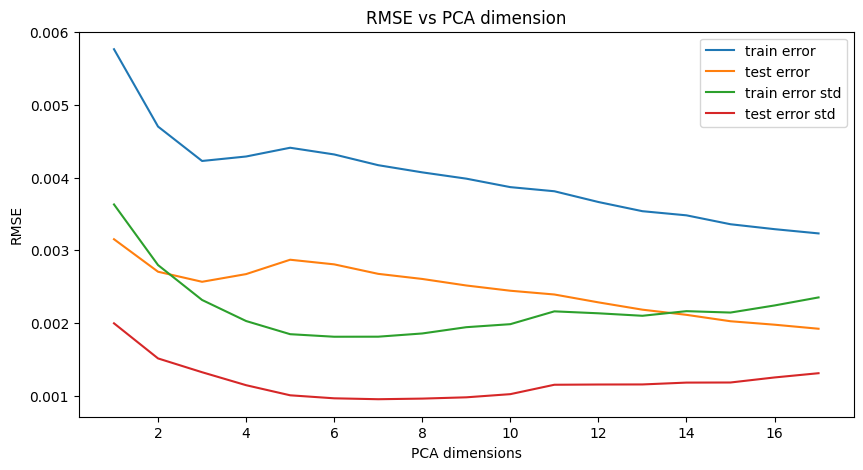

In [608]:
PCA_non_linear_test([lambda x: np.ones_like(x), lambda x: x, lambda x: x**2])

Fitting the nonlinear quadratic model we see a similar picture to the linear model, but with slightly less increase in the training error as the number of principle components is reduced. EXPAND ON THIS

## 3.3
training and testing a cubic polynomial model

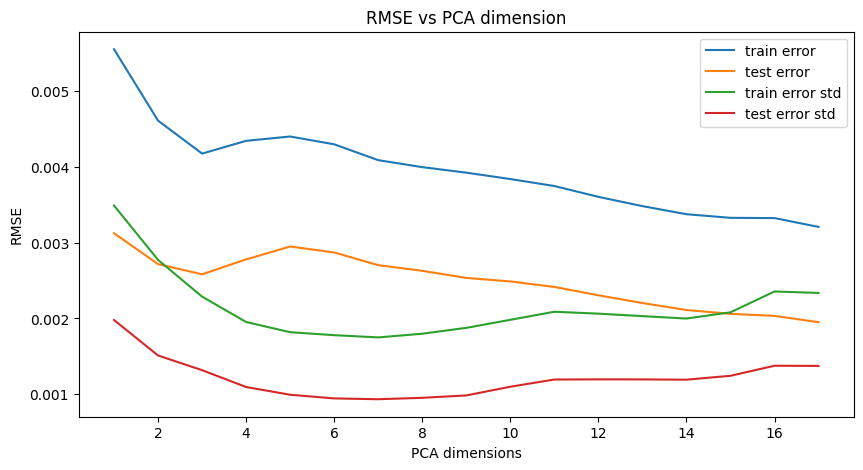

In [609]:
PCA_non_linear_test([lambda x: np.ones_like(x), lambda x: x, lambda x: x**2, lambda x: x**3])

Again, we see a similar picture.

## 3.4

Makes no sense given visualisations I have generated. Consider redoing this analysis explicitly using SVD instead of PCA

## 4.1

We can calculate the DMD of a linear system as a special case given
$$
\hat{\bm{x}}_{k+1} = W\hat{\bm{x}}_k
$$
where W is our learned linear model and $\hat{\bm{x}}_k$ is the state surrogate at timestep k.
Then koopman modes are
$$
h(\hat{\bm{x}}_{k+1}) = h(W\hat{\bm{x}}_k) = \lambda h(\hat{\bm{x}}_k)
$$
and if we assume that the koopman operator is given by 
$$
h(\hat{\bm{x}}) = \bm{v}^T\hat{\bm{x}}
$$
where $\bm{v}^T\hat{\bm{x}}$ is the eigenfunction of a particular koopman mode, we then have 
$$
W^T\bm{v} = \lambda\bm{v}^T
$$
Koopman modes include the eigenvalue, eigenfunction pairs of W (corresponding to left eigenvectors of W).

Because the koopman operator is linear, the rest of the koopman modes can be determined from the unique products of these solutions. For a linear model there are a finite number of koopman modes provided none of the eigenvalues are equal to one.


In [610]:
def linear_DMD(W):
    """
    return the eigenvalues and DMD matrix corresponding to the approximate koopman modes 
    a linear model, with square weight matrix W.
    
    Returns:
    --------
    W_eigvals: np.array, eigenvalues of the DMD matrix, sorted by decreasing magnitude
    dmd_mat: np.array, DMD matrix each row of which corresponds to a koopman function (left eigenvectors of W)
    """

    # we want the left eigenvectors, so we need to transpose W. W is of course symettric in this case so we can use eig
    W_eigvals, W_eigvecs = la.eig(W.T)
    # sorting the eigenvectors by the magnitude of the eigenvalues
    sort_indices = np.argsort(np.abs(W_eigvals))[::-1]
    W_eigvals = W_eigvals[sort_indices]
    W_eigvecs = W_eigvecs[:, sort_indices]

    # The first order DMD matrix is simply
    dmd_mat = W_eigvecs.T

    return W_eigvals, dmd_mat    

In [625]:
# let's just retrain the model to get the weights
W, U, X_prev, X_next = linear_delay_embedding(stacked_train_data, delay=8, kappa=1e6)

W_eigvals, dmd_mat = linear_DMD(W)

## 4.2

The residual of a given DMD mode, measures how close we are to an actual koopman mode. It is given by

$$
res(\lambda, h) = \frac{\|\Kappa h - \lambda h \|^2}{\|h\|^2}
$$

where $\kappa h$ is the actual koopman operator and $\lambda h$ is the DMD approximation. To approximate this residual with data, we can use the equation

$$
res(\lambda, h) \approx \frac{\bm{v}^*\big( L - \lambda H - \bar{\lambda}H^T + |\lambda|^2 G \big)\bm{v}}{\bm{v}^* G\bm{v}}
$$

where $G=XX^T$, $H=YX^T$ and $L = YY^T$

and in this case, since we have a linear model,
$Y=\hat{X}_{\mathrm{prev}}$, $X = \hat{X}_{\mathrm{prev}}$, with $Y = WX$

More precisely, the residual is the relative error between the approximate koopman mode and actual koopman mode.

In [626]:
## 4.2
def koopman_residue(X, Y, eigen_val, eigen_vec):
    """
    Calculates the approximate residual of the Koopman mode, corresponding to eigen_val and eigen_vec, 
    using the input and output state data X and Y.
    args:
    -----
    X: np.array, input state matrix of shape (n, m) where n is the number of features and m is the number of timesteps
    Y: np.array, output state matrix of shape (n, m) where n is the number of features and m is the number of timesteps
    koop_val: float, value of the koopman operator
    eigen_vec: np.array, eigenvector of the Koopman operator

    returns:
    --------
    residue: float, residue of the Koopman operator
    """

    G = X @ X.T
    H = Y @ X.T
    L = Y @ Y.T

    v = eigen_vec
    lam = eigen_val

    # shorthand for the hermitian transpose
    def HT(v: np.array) -> np.array:
        return np.conj(v).T
    
    res = HT(v) @ (L - lam*H - np.conj(lam)*HT(H) + np.abs(lam)**2*G) @ v
    res /= HT(v) @ G @ v

    # Because of machine precision, the residue can be a complex number with a very small imaginary part
    assert np.isclose(np.imag(res), 0, atol=1e-15), 'Residue is not real to machine precision'
    res = np.real(res)

    return res

lets calculate the residual of each of the modes

In [628]:
def sorted_koopman_residues(W_eigvals, dmd_mat, X_prev, X_next, return_inds=False):
    no_modes = W_eigvals.shape[-1]

    # getting the residue of each approximate koopman mode
    residues = []
    for i in range(no_modes):
        residue = koopman_residue(X_prev, X_next, W_eigvals[i], dmd_mat[i, :])
        residues.append(residue)
    residues = np.array(residues)
    
    # sorting the residues and the corresponding eigenvalues and eigenvectors by the residues
    sort_inds = np.argsort(residues)
    residues = residues[sort_inds]
    W_eigvals = W_eigvals[sort_inds]
    dmd_mat = dmd_mat[sort_inds, :]

    # returning the sorted residues, eigenvalues and dmd matrix (eigenvectors)
    if return_inds:
        return residues, W_eigvals, dmd_mat, sort_inds
    
    return residues, W_eigvals, dmd_mat

residues, W_eigvals, dmd_mat = sorted_koopman_residues(W_eigvals, dmd_mat, X_prev, X_next)

print("residues: ", residues)
print("number of modes: ", len(residues))

residues:  [0.00791286 0.00791286 0.02940535 0.02940535 0.08661085 0.1192131
 0.12065352 0.12065352 0.14673258 0.14673258 0.17315302 0.17315302
 0.23880866 0.23880866 0.25430415 0.25430415 0.27472614 0.27472614
 0.27505064 0.27505064 0.28348075 0.28348075 0.29203978 0.29203978
 0.29790916 0.31496842 0.32138056 0.32138056 0.3300592  0.3300592
 0.33457868 0.33457868 0.3550036  0.3550036  0.37107638 0.37107638
 0.37263945 0.37263945 0.37436298 0.37436298 0.37621182 0.37621182
 0.3774203  0.3774203  0.37832401 0.37832401 0.38652045 0.38652045
 0.39592764 0.39592764 0.40222153 0.40222153 0.40456332 0.40456332
 0.40958346 0.40958346 0.41541985 0.43260263 0.43260263 0.43862048
 0.43862048 0.45239246 0.45239246 0.45790074 0.45790074 0.46098706
 0.46098706 0.46708625 0.46708625 0.47104212 0.47104212 0.47545466
 0.47545466 0.47546002 0.47546002 0.48040734 0.48040734 0.48297545
 0.48297545 0.48514828 0.48514828 0.49053202 0.49053202 0.49214257
 0.49214257 0.49527154 0.49527154 0.50148954 0.501489

## 4.3

We have 136 modes because we are using a delay of 8 for our linear delay embedding model (17*8). We see that the worst residual is close to 1, which would indicate the approximate mode is off by a whole factor of the true solution. However, this might be the case if the eigenvalue of the mode is very close to zero. Let's take a look by plotting the eigenvalues in the complex plane, colorcoded by residue.

In [622]:
def plot_koopman_modes(eigvals, residues):
    """
    Plots the first n_modes Koopman modes, corresponding to the eigenvalues eigvals and eigvecs.
    args:
    -----
    eigvals: np.array, eigenvalues of the Koopman operator
    eigvecs: np.array, eigenvectors of the Koopman operator
    n_modes: int, number of modes to plot
    """
    fig, ax = plt.subplots()
    # seperating real and imaginary parts for plotting
    eigvals_x = np.real(eigvals)
    eigvals_y = np.imag(eigvals)
    scat = ax.scatter(eigvals_x, eigvals_y, c=residues, cmap='jet')
    # plot unit circle
    unit_circle = plt.Circle((0, 0), 1, color='r', fill=False, linestyle='--', label='unit circle')
    ax.add_artist(unit_circle)
    
    # formatting
    ax.set_xlabel('Real')
    ax.set_ylabel('Imaginary')
    ax.set_title('Koopman modes')
    plt.colorbar(scat, label='Residue')
    # setting limits so that the unit circle is central and visible
    ax.set_xlim(-1.1, 1.1)
    ax.set_ylim(-1.1, 1.1)
    ax.legend(loc='upper left')

    plt.show()

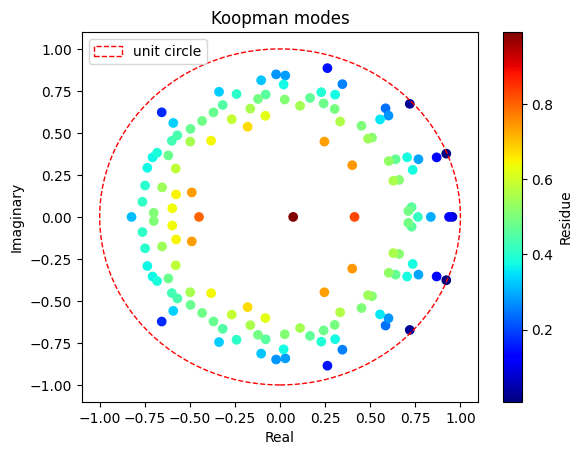

In [623]:
plot_koopman_modes(W_eigvals, residues)

We can see that our theory of smaller eigenvalues producing larger residuals is correct. Now when it comes to plotting the frequencies, that each koopman mode corresponds to, we must first consider what this means. We saw previously, that under the koopman operator, our linear observable system follows the update rule

$$
h(\hat{\bm{x}}_{k+1}) = \lambda h(\hat{\bm{x}}_k)
$$

meaning, given some timestep $\Delta t$ and initial output, producing the surrogate state $\hat{\bm{x}}_0$, we have the power rule

$$
h(\hat{\bm{x}}(t)) = \lambda^{t/\Delta t} h(\hat{\bm{x}}_0)
$$

which in exponential form is

$$
h(\hat{\bm{x}}(t)) = e^{\ln(\lambda)(t/\Delta t)} h(\hat{\bm{x}}_0)
$$

This can be rewritten as a decaying complex exponential, since $\ln(\lambda)$ is complex

$$
h(\hat{\bm{x}}(t)) = f(t)e^{i\theta t}
$$

where
$$
f(t) = h(\hat{\bm{x}}_0)e^{\frac{1}{\Delta t}\mathrm{Re}\{\ln(\lambda)\}t}
$$

and

$$
\theta = \frac{1}{\Delta t}\mathrm{Im}\{\ln(\lambda)\}
$$


A really cool implication of this, is that the full koopman space solution is a fourier series solution to the underlying system, since each koopman mode defines a decaying (since all the koopman eigenvalues lie in the complex unit circle) sinusoidal function. In any case, the frequency of the koopman mode corresponding to $h$ is given by $\theta$ (rad/s). The decay exponent of each koopman mode is also given by $\frac{1}{\Delta t}\mathrm{Re}\{\ln(\lambda)\}\,\, s^{-1}$

Let's plot this and we can go one step further and plot the sinsusoids corresponding to each mode.

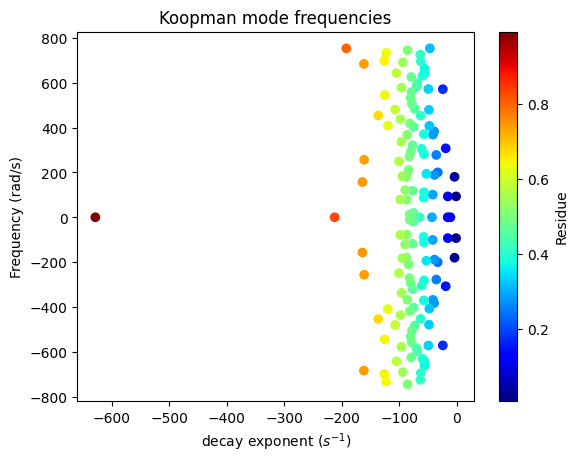

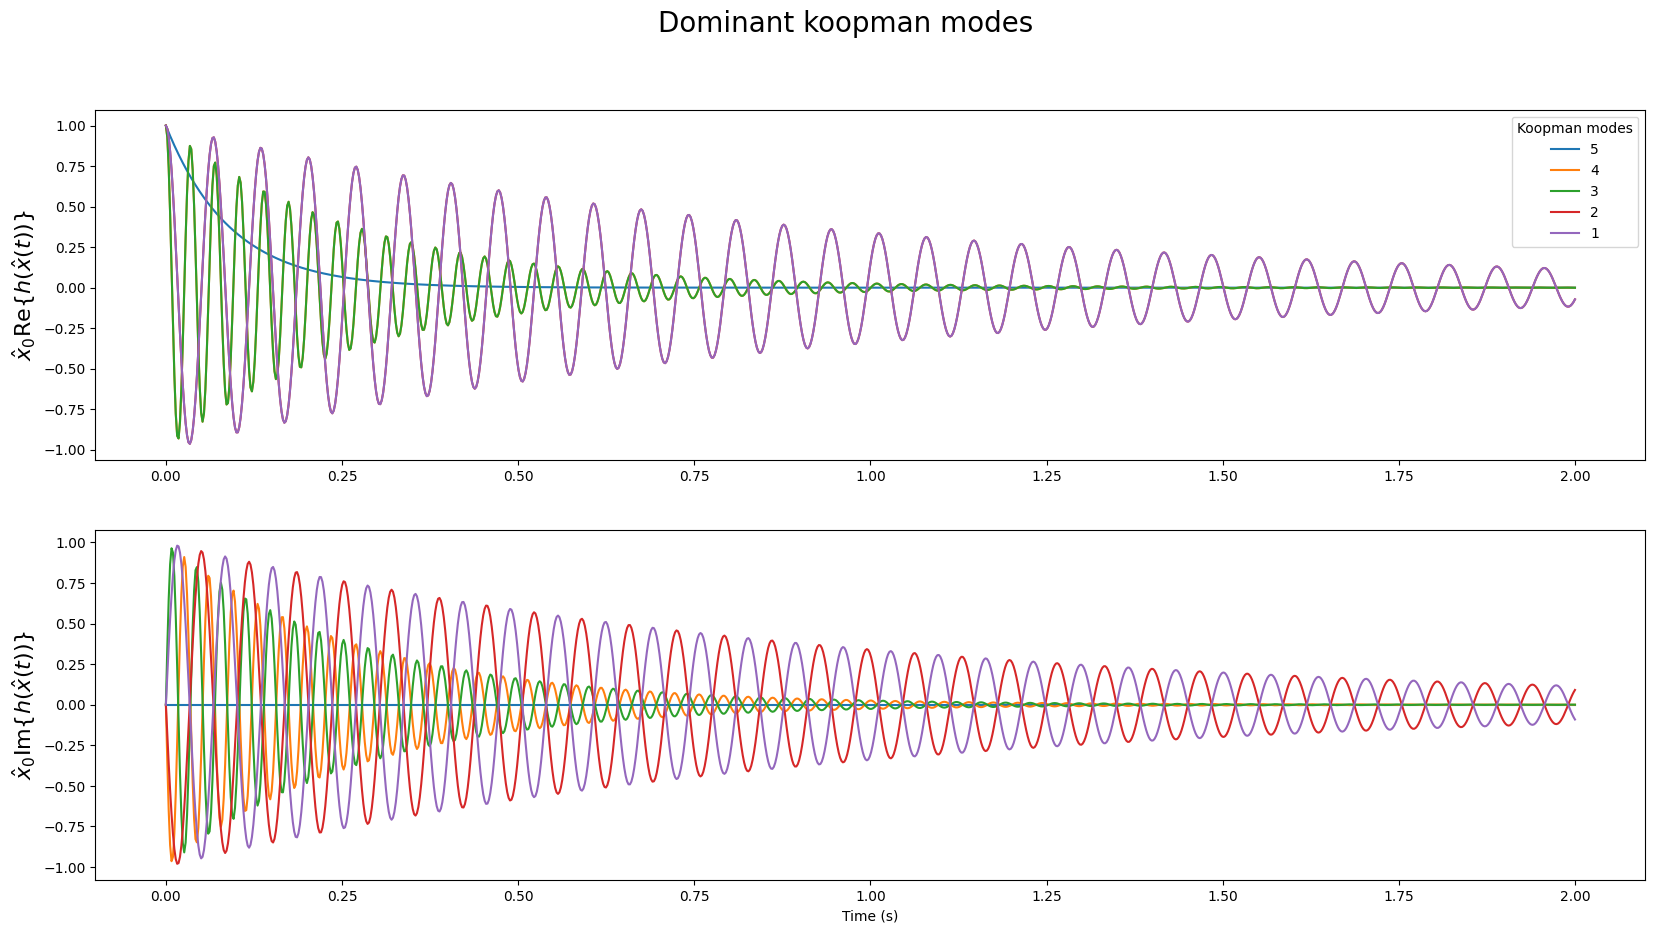

In [ ]:
def koopman_space_solution(eig_val, t, delta_t):
    """
    Calculates the koopman space state solution at time t, where ther koopman operator being solved is given by eig_val. 
    args:
    -----
    eig_val: float, eigenvalue of the Koopman operator
    t: float, time to evaluate the solution
    x_0: np.array, initial condition of the system

    returns:
    --------
    x_t: np.array, solution to the Koopman operator at time t
    """
    koop_xt = np.exp(1/delta_t * np.real(np.log(eig_val)) * t)*np.exp(1j/delta_t * np.imag(np.log(eig_val)) * t)
    return koop_xt


def plot_koopman_mode_frequencies(eig_vals, residuals, delta_t):
    """
    Plots the frequency of the Koopman modes, corresponding to the eigenvalues eig_vals and residuals.
    args:
    -----
    eig_vals: np.array, eigenvalues of the Koopman operator
    residuals: np.array, residues of the Koopman operator
    delta_t: float, time step between each state in the data
    """
    # calculating the frequencies of the Koopman modes
    freqs = 1/delta_t * np.imag(np.log(eig_vals))
    # calculating the decay exponents of the Koopman modes
    decay_expo = 1/delta_t * np.real(np.log(eig_vals))

    fig, ax = plt.subplots()
    scat = ax.scatter(decay_expo, freqs, c=residuals, cmap='jet')
    ax.set_xlabel('decay exponent ($s^{-1}$)')
    ax.set_ylabel('Frequency (rad/s)')
    ax.set_title('Koopman mode frequencies')
    plt.colorbar(scat, label='Residue')
    plt.show()

    slowest_decaying = np.argsort(decay_expo)[-5:]

    fig, axs = plt.subplots(2, 1, figsize=(20, 10))
    t = np.linspace(0, 2, 1000)
    for i in slowest_decaying:
        koop_sol = koopman_space_solution(eig_vals[i], t, delta_t)
        axs[0].plot(t, np.real(koop_sol), label=f'{i+1}')
        axs[1].plot(t, np.imag(koop_sol), label=f'{i+1}')
    
    axs[0].legend(title='Koopman modes')
    axs[0].set_ylabel(r'$\hat{x}_0\mathrm{Re}\{h(\hat{x}(t))\}$', fontsize=16)
    axs[1].set_ylabel(r'$\hat{x}_0\mathrm{Im}\{h(\hat{x}(t))\}$', fontsize=16)
    axs[1].set_xlabel('Time (s)')
    
    plt.suptitle('Dominant koopman modes', fontsize=20)
    plt.show()

# we can determine delta_t from the framerate of the camera
plot_koopman_mode_frequencies(W_eigvals, residues, 1/FRAME_RATE)


The top plot is a really powerful visualisation, as it shows us that our innacurate koopman modes correspond to system dynamics that very quickly decay to zero and the more accurate modes are more persistent in the system dynamics. We also see that there is a conjugate symmetry in the modes, corresponding to orthogonal oscillations.

The bottom plot shows the real and imaginary dimensionless response of the top 5 dominant koopman modes in koopman space. We can see that that modes 1 and 2, together with 3 and 4 are conjugate modes and that mode 5 is actually non oscillatory, instead exhibiting a real exponential decay and 0 imaginary part. when transforming from the koopman space to the surrogate state space, these modes will be linearly combined according to the eigenfunctions of each mode to produce the dynamics of each of the bolts.

## 4.4


In [686]:
# to implement bagging, we want to repeatedly fit the model to different ordered subsets of the data

def dmd_bagging(trails=50):
    """
    Finds the eigenvalue corresponding to the koopman mode with smallest residue repeatedly
    using bagging. The returned result can be used to quantify the uncertainty in the eigenvalue
    
    returns:
    --------
    eigvals: np.array, eigenvalues from each trial corresponding to the smallest residue
    residuals: np.array, residuals of the eigenvalues from each trial
    mean_eigval: np.array, 2 entry array with the mean of the eigenvalues in the real and imaginary plane
    cov_eigval: np.array, 2x2 array, covariance matrix of the eigenvalues in the real and imaginary plane
    """

    eigvals = []
    residuals = []
    signs = []
    for trial in tqdm(range(trails), desc='Bagging trials'):
        # randomly sampling 80% of the training data and sorting, so that there is some temporal skipping but time is still preserved
        inds = np.random.choice(stacked_train_data.shape[1], size=round(stacked_train_data.shape[1]*0.8), replace=False)
        inds = np.sort(inds)

        # retraining the model on the bagged data
        W, U, X_prev, X_next = linear_delay_embedding(stacked_train_data[:,inds], delay=8, kappa=1e6)
        W_eigvals, dmd_mat = linear_DMD(W) # solution is sorted by eigenvalue magnitude

        # calculating the residuals with all of the data is computationally expensive, so we will only do it for the first 100 columns
        residues, sorted_vals, sorted_dmd = sorted_koopman_residues(W_eigvals, dmd_mat, X_prev[:, :100], X_next[:, :100])
        
        for eigen_val, residue in zip(sorted_vals, residues):
            if not np.isclose(np.imag(eigen_val), 0, rtol=1e-4): # ensuring that the eigenvalue has at least a small imaginary part indicating oscillation
                if trial == 0 or np.all(np.sign(eigen_val) == signs):
                    eigvals.append(eigen_val)
                    residuals.append(residue)
                    signs = np.sign(eigen_val)
                break
        
    
    # eigenvals are complex so distribution is 2D, therefore we need to find the mean and covariance to characterise the distribution
    eigvals = np.array(eigvals)
    real_eigvals = np.real(eigvals)
    imag_eigvals = np.imag(eigvals)

    mean_eigval = [np.mean(real_eigvals), np.mean(imag_eigvals)]
    cov_eigval = np.cov(np.vstack([real_eigvals, imag_eigvals]))

    return eigvals, residuals, mean_eigval, cov_eigval


def visualise_complex_gaussian(obs, residuals, mean, cov):
    """
    Visualises a 2D complex gaussian distribution given by the mean and covariance
    args:
    -----
    obs: np.array, observed data points
    residuals: np.array, residuals of the observed data points
    mean: np.array, mean of the complex gaussian
    cov: np.array, covariance matrix of the complex gaussian
    """
    gaus_2d = multivariate_normal(mean=mean, cov=cov)
    real_range = (np.min(np.real(obs)), np.max(np.real(obs)))
    imag_range = (np.min(np.imag(obs)), np.max(np.imag(obs)))
    real, imag = np.meshgrid(np.linspace(*real_range, 100), np.linspace(*imag_range, 100))

    # plotting 
    fig, ax = plt.subplots()
    
    ax.contourf(real, imag, gaus_2d.pdf(np.dstack([real, imag])))
    scat = ax.scatter(np.real(obs), np.imag(obs), c=residuals, label='observed', cmap='jet')
    ax.set_xlabel('Real')
    ax.set_ylabel('Imaginary')
    ax.set_title('Complex Gaussian distribution')
    ax.set_xlim(real_range)
    ax.set_ylim(imag_range)
    plt.colorbar(scat, label='Residue')
    plt.legend()
    plt.show()


         

In [679]:
bagged_eigvals, residuals, mean, cov = dmd_bagging(trails=50)
print("mean eigenvalue: ", mean)
print("covariance of eigenvalues: ", cov)

Bagging trials: 100%|██████████| 50/50 [00:11<00:00,  4.23it/s]

mean eigenvalue:  [0.8637408172131338, 0.45003400085037093]
covariance of eigenvalues:  [[ 1.13291529e-05 -6.14447131e-06]
 [-6.14447131e-06  1.02897539e-05]]


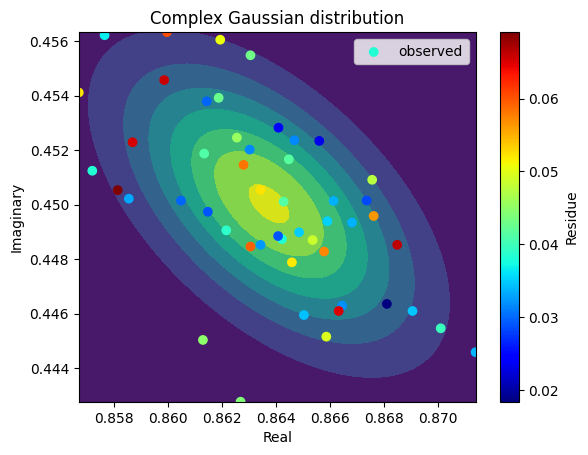

In [687]:
visualise_complex_gaussian(bagged_eigvals, residuals, mean, cov)

## 4.5

We know that the vibration frequency of a given koopman mode is proportional to the log of the imaginary component of the eigenvalue.
More specifically

$$
\theta = \frac{1}{\Delta t}\mathrm{Im}\{\ln(\lambda)\}
$$

we can use the covariance matrix to get an estimate of the standard deviation in the imaginary axis, which quantifies our uncertainty. The corresponding uncertainty of the frequency $\theta$ can be calculated as follows (assuming all other variables are certain)

In [699]:
im_sig = np.sqrt(cov[1,1])
im_mean = mean[1]
# 95% confidence interval is
interval_95 = norm.interval(0.95, loc=im_mean, scale=im_sig)
print(r"95% confidence interval = ", interval_95)

theta_uncertainty = FRAME_RATE * (np.log(interval_95[1]) - np.log(mean[1]))
print(r"theta 95% uncertainty =  +-", theta_uncertainty, "rad/s")

95% confidence interval =  (0.4437468977124534, 0.45632110398828846)
theta 95% uncertainty =  +- 3.329663941634191 rad/s
